### Medium Term Model  
Due to its temporal complexity, Hydro Power Decision Making is typically split up into multiple problems. We explore a seasonal model with a timeframe of 6-18 months. We try to answer the question when to use water for power production governed by price and inflow variations.  
A key uncertainty of hydropower is inflow. Yearly variations of total inflow are around 30%.

The goal of this model is to be used input in the short term model for decision making. Therefore, it is simply a tool to improve the decision making we make in the short term.  

#### Water Value Cuts

The way this model is integrated into the short-term is by a Water Value Function $V(l)$. In the objective of the short term model we include 

$$
- \sum\limits_{r \in \mathcal{R}}V(l_{r,t}) - V(l_{r,t+1})
$$

If the reservoir is less full at $t+1$ than at $t$, the piece-wise linear and concave function penalizes the objective. 


In [1]:
using JuMP
using CPLEX
using Distributions
using LinearAlgebra
using Statistics
using Dates
using DataFrames
using SDDP
using Plots
import CSV
using JSON
try
    using Revise
catch e
    @warn "Error initializing Revise" exception=(e, catch_backtrace())
end

includet(pwd() * "\\Water_Regulation\\WaterRegulation.jl")
using .WaterRegulation

The approach is to generate approximations to the Water Value Function (which is already difficult to define in the first place).

* Solve the medium-term model
* Obtain dual solution $\pi_r$ corresponding to the balance constraints of the reservoirs -> Gradient for Water Value
* Obtain objective function value $\varphi_M(l)$
* Form the cut coefficients for each cut $c$ from both informations for different reservoir levels.

Mathematically speaking, we are trying to find cuts of the following form:

$$
\alpha_r^c \leq \varphi_M^c(l^c_r) - \pi_r^c \cdot (l_{r}^c - l_{r,t+1})
$$


### Coefficients and Parameters

In [2]:
filepath_Ljungan = pwd() * "\\Water_Regulation\\TestDataWaterRegulation\\Ljungan.json"
filepath_prices = pwd() *  "\\Data\\Spot Prices\\prices_df.csv"
filepath_results = pwd() * "\\Results\\LambdaZero\\"
R, K, J = read_data(filepath_Ljungan)
print() 

j = J[1]
O = OtherParticipant(J, j , R)[1]
K_j = [j.plants[1]]
K_O = [O.plants[1]]
pj = j.participationrate
pO = O.participationrate


println("Participation rate $(j.name): \n ", pj)
println("Participation rate $(O.name): \n ", pO)
println("K_O : $(K_O) and spillage $(K_O[1].spillreference),\nK_j : $(K_j) and spillage $(K_j[1].spillreference)")

T = 7 # Days in a Week
W = 52 # Weeks in time horizon (26-78, depending on the day we are looking at)

Participation rate Sydkraft: 
 ________________________________
Flasjon  | 1.84    
Holsmjon | 0.0     

Participation rate Other: 
 ________________________________
Flasjon  | 2.68    
Holsmjon | 2.68    



K_O : HydropowerPlant[Parteboda] and spillage 1.4,
K_j : HydropowerPlant[Flasjo] and spillage 0.58


52

### Price & Inflows

23.0
52


NamedTuple{(:in, :pr), Tuple{Float64, Float64}}[(in = 1.0, pr = 12.0), (in = 1.0, pr = 18.0), (in = 4.0, pr = 12.0), (in = 4.0, pr = 18.0), (in = 6.0, pr = 12.0), (in = 6.0, pr = 18.0)]


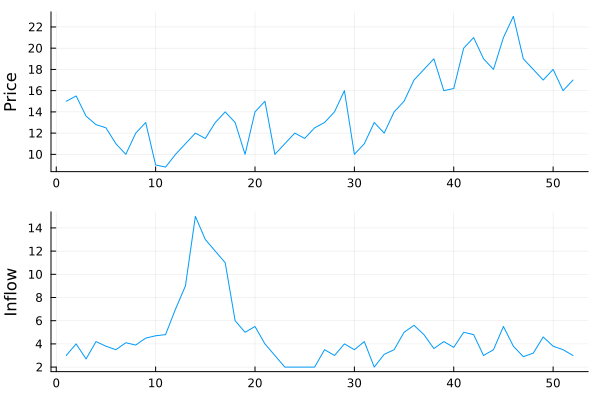

In [3]:
price = [15.0, 15.5, 13.6, 12.8, 12.5, 11.0, 10.0, 12.0, 13.0, 9.0, 8.8, 10.0, 11.0, 12.0, 11.5, 13.0, 14.0, 13.0, 10.0, 14.0, 15.0, 10.0, 11.0, 12.0, 11.5, 12.5, 13.0, 14.0, 16.0, 10.0, 11.0, 13.0, 12.0, 14.0, 15.0, 17.0, 18.0, 19.0, 16.0, 16.2, 20.0, 21.0, 19.0, 18.0, 21.0, 23.0, 19.0, 18.0, 17.0, 18.0, 16.0, 17.0]
inflow = [3.0, 4.0, 2.7, 4.2, 3.8, 3.5, 4.1, 3.9, 4.5, 4.7, 4.8, 7.0, 9.0, 15.0, 13.0, 12.0, 11.0, 6.0, 5.0, 5.5, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 3.5, 3.0, 4.0, 3.5, 4.2, 2.0, 3.1, 3.5, 5.0, 5.6, 4.8, 3.6, 4.2, 3.7, 5.0, 4.8, 3.0, 3.5, 5.5, 3.8, 2.9, 3.2, 4.6, 3.8, 3.5, 3.0] 

println(maximum(price))
println(length(inflow))
inflow_var = [-2.0, 1.0, 3.0]
price_var = [-3.0, 3.0]
P  = [0.2, 0.2, 0.1, 0.2, 0.2, 0.1] 
Omega = Dict(t => [(in = inflow[t] + el_i, pr = price[t] + el_p) for el_i in inflow_var for el_p in price_var] for t in 1:52)
println(Omega[1])
Plots.plot(
    Plots.plot(price, ylabel = "Price"),
    Plots.plot(inflow, ylabel = "Inflow"),
    layout = (2,1),
    legend = false,
    show = true,
)

In [4]:
function subproblem_builder_medium(subproblem::Model, node::Int64)
    # State Variables
    @variable(subproblem, 0 <= l[r = R] <= r.maxvolume, initial_value = r.currentvolume / 10, SDDP.State)
    # Control Variables
    @variable(subproblem, Q[r = R] >= 0)
    @variable(subproblem, s[r = R] >= 0)
    @variable(subproblem, w[k = K] <= k.spillreference * k.equivalent)
    # Random Variables
    @variable(subproblem, f[r = R])
    # Transition Function 
    @constraint(subproblem, balance[r = R],  l[r].out == l[r].in - T * 24 * Q[r] + T *  f[r] - s[r])
    # Constraints
    # @constraint(subproblem, balance_limits[r = R], lmin[node] <=  l[r].out <= lmax[node])
    @constraint(subproblem, production[k = K], w[k] <= sum(Q[r] for r in find_us_reservoir(k.reservoir)) * k.equivalent)
    # Objective
    # Parameterize Uncertainty
    SDDP.parameterize(subproblem, Omega[node], P) do om
        for r in R
            JuMP.fix(f[r], om.in)
        end
        @stageobjective(subproblem, om.pr * sum(w[k] for k in K))
    end
end


subproblem_builder_medium (generic function with 1 method)

In [5]:
println("Upper Bound: ", sum(r.currentvolume * maximum(price) * sum(k.equivalent for k in K) for r in R))

graph = SDDP.LinearGraph(52)

model_medium = SDDP.PolicyGraph(
    subproblem_builder_medium,
    graph;
    sense = :Max,
    upper_bound = sum(1/10 *  r.currentvolume * maximum(price) * sum(k.equivalent for k in K) for r in R),
    optimizer = CPLEX.Optimizer
)

Upper Bound: 2.9108800000000005e6


A policy graph with 52 nodes.
 Node indices: 1, ..., 52


In [6]:
SDDP.train(model_medium; iteration_limit = 100)

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------


problem
  nodes           : 52
  state variables : 2
  scenarios       : 2.90981e+40


  existing cuts   : false
options
  solver          : serial mode
  risk measure    : 

SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [24, 24]
  VariableRef in MOI.LessThan{Float64}    : [16, 16]
  AffExpr in MOI.LessThan{Float64}        : [13, 13]
  VariableRef in MOI.GreaterThan{Float64} : [6, 7]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]


numerical stability report
  matrix range     [7e-02, 2e+02]
  objective range  [1e+00, 3e+01]
  bounds range     [7e-02, 3e+05]
  rhs range        [0e+00, 0e+00]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-------------------------------------------------------------------


         1   1.198615e+03  3.441535e+03  1.873000e+01       364   1


         2   5.439999e+02  3.409196e+03  1.903500e+01       728   1


         3   2.347261e+03  3.309810e+03  1.942200e+01      1092   1
         4   2.269340e+03  3.290343e+03  1.951700e+01      1456   1


         5   2.301963e+03  2.616703e+03  1.961400e+01      1820   1
         6   2.438572e+03  2.616700e+03  1.970300e+01      2184   1


         7   2.434196e+03  2.608090e+03  1.980700e+01      2548   1
         8   2.429389e+03  2.607713e+03  1.990100e+01      2912   1


         9   2.458638e+03  2.601471e+03  1.999400e+01      3276   1


        10   2.436226e+03  2.594425e+03  2.009700e+01      3640   1
 

       11   2.574121e+03  2.594374e+03  2.019600e+01      4004   1
        12   2.576116e+03  2.574688e+03  2.029400e+01      4368   1


        13   2.582057e+03  2.574185e+03  2.039800e+01      4732   1


        14   2.704426e+03  2.573680e+03  2.050000e+01      5096   1


        15   2.573524e+03  2.573545e+03  2.060400e+01      5460   1


        16   2.713807e+03  2.573242e+03  2.079900e+01      5824   1


        17   2.652621e+03  2.572963e+03  2.090100e+01      6188   1


        18   2.589329e+03  2.572847e+03  2.101600e+01      6552   1


        19   2.664184e+03  2.572749e+03  2.112000e+01      6916   1


        20   2.532557e+03  2.572642e+03  2.122800e+01      7280   1


        21   2.563166e+03  2.572495e+03  2.134800e+01      7644   1


        22   2.693150e+03  2.571955e+03  2.145500e+01      8008   1


        23   2.630841e+03  2.571884e+03  2.156100e+01      8372   1


        24   2.548616e+03  2.571606e+03  2.167500e+01      8736   1


        25   2.592462e+03  2.571575e+03  2.179200e+01      9100   1


        26   2.352413e+03  2.571573e+03  2.191000e+01      9464   1


        27   2.528444e+03  2.571458e+03  2.202700e+01      9828   1


        28   2.391569e+03  2.571329e+03  2.213800e+01     10192   1


        29   2.452022e+03  2.571241e+03  2.225000e+01     10556   1


        30   2.530625e+03  2.571013e+03  2.238200e+01     10920   1


        31   2.551993e+03  2.570928e+03  2.249000e+01     11284   1


        32   2.440242e+03  2.570878e+03  2.260600e+01     11648   1


        33   2.656235e+03  2.570821e+03  2.272600e+01     12012   1


        34   2.525506e+03  2.570703e+03  2.283500e+01     12376   1


        35   2.376414e+03  2.570473e+03  2.294100e+01     12740   1


        36   2.557163e+03  2.570463e+03  2.304300e+01     13104   1


        37   2.661480e+03  2.570437e+03  2.314600e+01     13468   1


        38   2.483430e+03  2.570378e+03  2.325300e+01     13832   1


        39   2.643480e+03  2.570022e+03  2.336800e+01     14196   1


        40   2.649348e+03  2.569895e+03  2.348800e+01     14560   1


        41   2.578869e+03  2.569773e+03  2.369100e+01     14924   1


        42   2.531866e+03  2.569613e+03  2.380400e+01     15288   1
        43   2.552618e+03  2.569588e+03  2.390000e+01     15652   1


        44   2.750216e+03  2.569533e+03  2.399100e+01     16016   1
        45   2.650477e+03  2.569434e+03  2.408300e+01     16380   1


        46   2.800981e+03  2.569316e+03  2.417400e+01     16744   1
        47   2.698267e+03  2.569217e+03  2.427000e+01     17108   1


        48   2.504651e+03  2.569054e+03  2.437500e+01     17472   1


        49   2.533682e+03  2.568784e+03  2.447700e+01     17836   1


        50   2.588701e+03  2.568698e+03  2.460100e+01     18200   1
        51   2.522359e+03  2.568380e+03  2.468400e+01     18564   1


        52   2.545033e+03  2.568373e+03  2.477300e+01     18928   1
        53   2.620251e+03  2.568027e+03  2.486600e+01     19292   1


        54   2.552378e+03  2.567963e+03  2.495900e+01     19656   1
        55   2.584685e+03  2.567865e+03  2.505300e+01     20020   1


        56   2.514072e+03  2.567824e+03  2.514900e+01     20384   1
        57   2.648076e+03  2.567720e+03  2.524200e+01     20748   1


        58   2.562635e+03  2.567549e+03  2.534400e+01     21112   1
 

       59   2.378921e+03  2.567470e+03  2.544300e+01     21476   1
        60   2.549096e+03  2.567288e+03  2.554100e+01     21840   1


        61   2.483459e+03  2.567241e+03  2.563500e+01     22204   1
        62   2.718829e+03  2.567233e+03  2.573400e+01     22568   1


        63   2.338467e+03  2.567155e+03  2.582900e+01     22932   1


        64   2.544451e+03  2.567151e+03  2.593100e+01     23296   1
        65   2.534051e+03  2.567104e+03  2.602500e+01     23660   1


        66   2.617802e+03  2.567095e+03  2.612600e+01     24024   1


        67   2.449498e+03  2.567060e+03  2.628300e+01     24388   1
        68   2.768234e+03  2.566961e+03  2.637300e+01     24752   1


        69   2.601059e+03  2.566891e+03  2.646200e+01     25116   1
        70   2.493669e+03  2.566793e+03  2.655500e+01     25480   1


        71   2.444921e+03  2.566774e+03  2.664300e+01     25844   1
        72   2.641510e+03  2.566644e+03  2.673600e+01     26208   1


        73   2.426691e+03  2.566523e+03  2.682800e+01     26572   1
        74   2.630963e+03  2.566468e+03  2.692500e+01     26936   1


        75   2.528341e+03  2.566422e+03  2.701900e+01     27300   1


        76   2.571364e+03  2.566317e+03  2.713100e+01     27664   1
        77   2.694284e+03  2.566257e+03  2.722400e+01     28028   1


        78   2.617562e+03  2.566226e+03  2.732200e+01     28392   1


        79   2.576924e+03  2.566206e+03  2.742900e+01     28756   1
        80   2.526747e+03  2.566195e+03  2.752700e+01     29120   1


        81   2.671728e+03  2.566185e+03  2.762400e+01     29484   1


        82   2.623627e+03  2.566129e+03  2.772700e+01     29848   1
        83   2.609053e+03  2.566105e+03  2.782500e+01     30212   1


        84   2.591564e+03  2.566041e+03  2.791700e+01     30576   1


        85   2.579916e+03  2.566036e+03  2.801900e+01     30940   1


        86   2.450616e+03  2.565996e+03  2.812200e+01     31304   1


        87   2.531551e+03  2.565970e+03  2.822800e+01     31668   1


        88   2.600729e+03  2.565930e+03  2.833100e+01     32032   1


        89   2.478610e+03  2.565843e+03  2.843600e+01     32396   1
        90

   2.649637e+03  2.565830e+03  2.853600e+01     32760   1


        91   2.664248e+03  2.565828e+03  2.864500e+01     33124   1


        92   2.487122e+03  2.565820e+03  2.874500e+01     33488   1


        93   2.490110e+03  2.565802e+03  2.889800e+01     33852   1
        94   2.669954e+03  2.565748e+03  2.899500e+01     34216   1


        95   2.713593e+03  2.565733e+03  2.909100e+01     34580   1
        96   2.520716e+03  2.565670e+03  2.918400e+01     34944   1


        97   2.461084e+03  2.565551e+03  2.928100e+01     35308   1
        98   2.505526e+03  2.565498e+03  2.937800e+01     35672   1


        99   2.635841e+03  2.565442e+03  2.947500e+01     36036   1
       100   2.733856e+03  2.565439e+03  2.957100e+01     36400   1


-------------------------------------------------------------------
status         : iteration_limit
total time (s) : 2.957100e+01
total solves   : 36400
best bound     :  2.565439e+03
simulation ci  :  2.523953e+03 ± 5.162298e+01
numeric issues : 0
-------------------------------------------------------------------



### Simulations

Test Plot for one Replication

[1851.6, 1689.1999999999998, 1631.6599999999999, 1570.62, 1618.2199999999998, 1628.7199999999998, 1643.4199999999998, 1580.2799999999997, 1500.3399999999997, 1540.2399999999998, 1594.8399999999997, 1629.8399999999997, 1678.8399999999997, 1707.3999999999996, 1805.3999999999996, 1777.9599999999996, 1778.5199999999995, 1730.0799999999995, 1786.0799999999995, 1810.5799999999995, 1824.5799999999995, 1831.5799999999995, 1852.5799999999995, 1887.5799999999995, 1922.5799999999995, 1922.5799999999995, 1968.0799999999995, 1975.0799999999995, 2024.0799999999995, 2069.5799999999995, 2084.9799999999996, 2105.9799999999996, 2016.2399999999993, 2026.7399999999993, 1892.3399999999992, 1855.0999999999992, 1719.299999999999, 1633.059999999999, 1683.4599999999991, 1518.9599999999991, 1398.559999999999, 1241.7599999999989, 1093.3599999999988, 1027.4199999999987, 875.5199999999987, 732.7199999999988, 583.6199999999988, 436.61999999999875, 299.4199999999987, 233.3185905224747, 88.41859052247469, 0.0]
[0.179

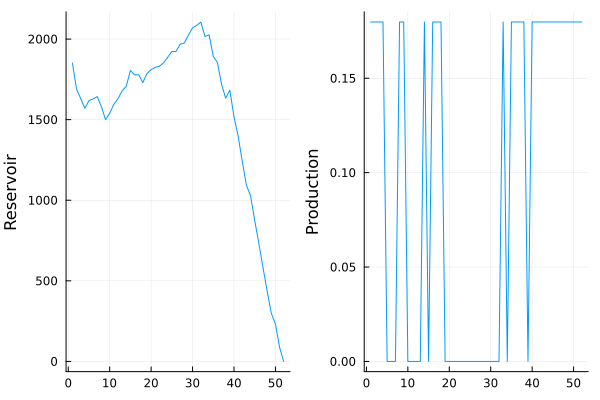

In [7]:
n = 100
simulations = SDDP.simulate(model_medium, n, [:l, :w]);

l_sim = [sim[:l][R[1]].out for sim in simulations[1]]
w_sim = [sim[:w][K[1]] for sim in simulations[1]]

println(l_sim)
println(w_sim)


Plots.plot(
    Plots.plot(l_sim, ylabel = "Reservoir"),
    Plots.plot(w_sim, ylabel = "Production"),
    legend = false,
    show = true,
)

### Spaghetti Plot

In [8]:
plot = SDDP.SpaghettiPlot(simulations)
SDDP.add_spaghetti(plot; title = "Reservoir") do sim
    return sum(sim[:l][r].out for r in R)
end
SDDP.add_spaghetti(plot; title = "Production") do sim
    return sum(sim[:w][k] for k in K)
end
SDDP.plot(
    plot,
    "spaghetti_plot.html";
    # We need this to build the documentation. Set to true if running locally.
    open = true,
)

### Obtain Water Values 

We trained the model and simulated it for different uncertainty realizations.
Next we obtain the Water Values for different initial conditions. How does the water value differ?

In [9]:
V = SDDP.ValueFunction(model_medium; node = 1)
cost, price = SDDP.evaluate(V, Dict(Symbol("l[$(r)]") => r.maxvolume for r in R))
println(cost)

11484.173283122549


Here we get the objective value and the gradient for both reservoirs. The gradient is positive, as an increase in reservoir capacity leads to an improvement in the objective function.  
We can plot the value function for multiple initial reservoir levels:

LinRange{Float64}(0.0, 20000.0, 100)LinRange{Float64}(0.0, 8000.0, 100)
FlasjonHolsmjon


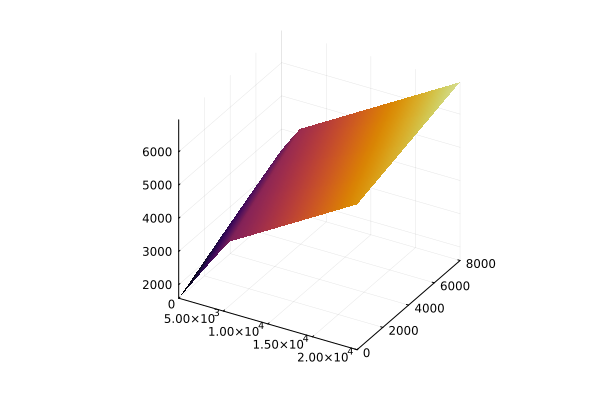

In [10]:
bounds_1 = LinRange(0.0, R[1].currentvolume, 100)
bounds_2 = LinRange(0.0, R[2].currentvolume, 100)
println(bounds_1, bounds_2)
println(R[1], R[2])
f(x, y) = SDDP.evaluate(V, (Symbol("l[Holsmjon]") => y, Symbol("l[Flasjon]") => x))[1]
surface(bounds_1, bounds_2, f, legend = false)

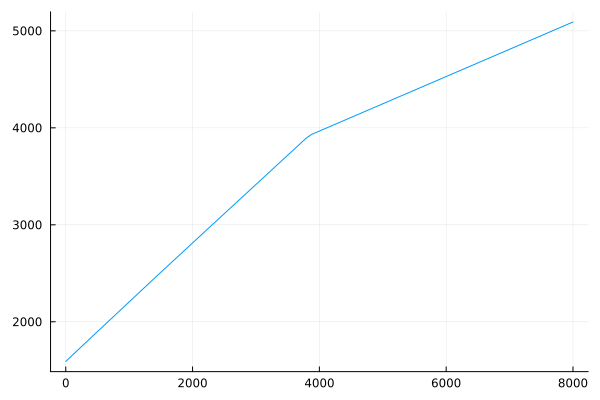

In [11]:
g(x) = SDDP.evaluate(V, (Symbol("l[Holsmjon]") => x, Symbol("l[Flasjon]") => x))[1]

Plots.plot(bounds_2, g, legend=false)

## To-Do

* Use real water data and real price data (average)
* Get average inflow values and confidence intervals for inflow variations (hopefully gaussian distribution)